In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks, welch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, r2_score,mean_absolute_error, root_mean_squared_error

In [2]:
df = pd.read_csv('Impact-events-dataset/merged_dataset.csv', delimiter=';')
print(df.head())
df.drop(columns = ['sampleNo', 'typeofimpact', 'ID'], inplace = True)
print(len(df))

   sensorA  sensorB  sensorC  sensorD  sampleNo typeofimpact position     x  \
0     1788     1796     1789     1783         0         ball      4_4  22.3   
1     1791     1789     1793     1792         1         ball      4_4  22.3   
2     1784     1796     1802     1783         2         ball      4_4  22.3   
3     1792     1795     1778     1789         3         ball      4_4  22.3   
4     1801     1777     1800     1791         4         ball      4_4  22.3   

      y  height    ID  experimentNo  
0  23.7    12.5  85.0             1  
1  23.7    12.5  85.0             1  
2  23.7    12.5  85.0             1  
3  23.7    12.5  85.0             1  
4  23.7    12.5  85.0             1  
3855000


In [4]:
positions_to_remove = ['1_1', '1_5', '5_1', '5_5']

df1 = df[~df['position'].isin(positions_to_remove)]
print(len(df1))
print(len(df))

3855000
3855000


In [5]:
sensor_columns = ['sensorA', 'sensorB', 'sensorC', 'sensorD']
print(df[sensor_columns].describe())

            sensorA       sensorB       sensorC       sensorD
count  3.855000e+06  3.855000e+06  3.855000e+06  3.855000e+06
mean   1.790466e+03  1.794333e+03  1.793815e+03  1.792419e+03
std    8.682298e+01  1.015747e+02  8.367260e+01  1.005864e+02
min   -3.570000e+02 -3.850000e+02 -3.520000e+02 -3.710000e+02
25%    1.775000e+03  1.781000e+03  1.780000e+03  1.782000e+03
50%    1.796000e+03  1.799000e+03  1.799000e+03  1.797000e+03
75%    1.810000e+03  1.812000e+03  1.812000e+03  1.809000e+03
max    4.048000e+03  4.057000e+03  4.040000e+03  4.055000e+03


Get the features = mean, std, min, max, skewness, kurtosis, energy, height.

In [6]:
def extract_features(group):
    features = {}
    sensors = ['sensorA', 'sensorB', 'sensorC', 'sensorD']

    for sensor in sensors:
        data = group[sensor]
        
        features[f'{sensor}_mean'] = data.mean()
        features[f'{sensor}_std'] = data.std()
        features[f'{sensor}_min'] = data.min()
        features[f'{sensor}_max'] = data.max()
        features[f'{sensor}_skew'] = skew(data)
        features[f'{sensor}_kurtosis'] = kurtosis(data)
        features[f'{sensor}_energy'] = np.sum(data**2)

        #fft_vals = np.fft.fft(data)
        #fft_freqs = np.fft.fftfreq(len(data))

        #fft_magnitude = np.abs(fft_vals)

        #features[f'{sensor}_fft_mean'] = np.mean(fft_magnitude)
        #features[f'{sensor}_fft_std'] = np.std(fft_magnitude)
        #features[f'{sensor}_fft_max'] = np.max(fft_magnitude)
        #features[f'{sensor}_fft_dominant_freq'] = fft_freqs[np.argmax(fft_magnitude)]

    features['height'] = group['height'].iloc[0]
    features['x'] = group['x'].iloc[0]
    features['y'] = group['y'].iloc[0]

    return pd.Series(features)

features_df = df.groupby('experimentNo').apply(extract_features).reset_index(drop=True)

X = features_df.drop(columns=['x', 'y']) 
y = features_df[['x', 'y']] 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)


Training Features Shape: (539, 29)
Testing Features Shape: (232, 29)
Training Target Shape: (539, 2)
Testing Target Shape: (232, 2)


C:\Users\kunal\AppData\Local\Temp\ipykernel_19312\1952150266.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_df = df.groupby('experimentNo').apply(extract_features).reset_index(drop=True)


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

n_estimators = 50
max_depth = 8
max_samples = 280  
n_iterations = 10


mse_X = []
mse_Y = []
mae_X = []
mae_Y = []
r2_X = []
r2_Y = []

for i in range(n_iterations):
    print(f"Iteration {i+1}:")
    
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_samples=max_samples,  
        random_state=i  
    )
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    mse_x = root_mean_squared_error(y_test['x'], y_pred[:, 0])
    mse_X.append(mse_x)
    
    mse_y = root_mean_squared_error(y_test['y'], y_pred[:, 1])
    mse_Y.append(mse_y)
    
    mae_x = mean_absolute_error(y_test['x'], y_pred[:, 0])
    mae_X.append(mae_x)
    
    mae_y = mean_absolute_error(y_test['y'], y_pred[:, 1])
    mae_Y.append(mae_y)
    
    r2_x = r2_score(y_test['x'], y_pred[:, 0])
    r2_X.append(r2_x)
    
    r2_y = r2_score(y_test['y'], y_pred[:, 1])
    r2_Y.append(r2_y)
    
    print(f"MSE for x: {mse_x:.4f}, MSE for y: {mse_y:.4f}")
    print(f"MAE for x: {mae_x:.4f}, MAE for y: {mae_y:.4f}")
    print(f"R2 for x: {r2_x:.4f}, R2 for y: {r2_y:.4f}")

average_RMSE_X = np.mean(mse_X)
average_RMSE_Y = np.mean(mse_Y)

average_MAE_X = np.mean(mae_X)
average_MAE_Y = np.mean(mae_Y)

average_R2_X = np.mean(r2_X)
average_R2_Y = np.mean(r2_Y)

print("\nSummary of Metrics:")
print(f"Average RMSE over {n_iterations} iterations for x: {average_RMSE_X:.4f}")
print(f"Average RMSE over {n_iterations} iterations for y: {average_RMSE_Y:.4f}")
print(f"Average MAE over {n_iterations} iterations for x: {average_MAE_X:.4f}")
print(f"Average MAE over {n_iterations} iterations for y: {average_MAE_Y:.4f}")
print(f"Average R2 over {n_iterations} iterations for x: {average_R2_X:.4f}")
print(f"Average R2 over {n_iterations} iterations for y: {average_R2_Y:.4f}")


Iteration 1:
MSE for x: 2.3187, MSE for y: 2.4575
MAE for x: 1.6624, MAE for y: 1.8368
R2 for x: 0.9100, R2 for y: 0.8960
Iteration 2:
MSE for x: 2.2944, MSE for y: 2.5972
MAE for x: 1.6916, MAE for y: 1.9124
R2 for x: 0.9118, R2 for y: 0.8838
Iteration 3:
MSE for x: 2.1740, MSE for y: 2.4111
MAE for x: 1.6212, MAE for y: 1.8354
R2 for x: 0.9209, R2 for y: 0.8998
Iteration 4:
MSE for x: 2.3246, MSE for y: 2.4185
MAE for x: 1.6511, MAE for y: 1.8413
R2 for x: 0.9095, R2 for y: 0.8992
Iteration 5:
MSE for x: 2.1985, MSE for y: 2.5121
MAE for x: 1.6074, MAE for y: 1.8528
R2 for x: 0.9191, R2 for y: 0.8913
Iteration 6:
MSE for x: 2.2898, MSE for y: 2.6444
MAE for x: 1.6479, MAE for y: 1.9976
R2 for x: 0.9122, R2 for y: 0.8795
Iteration 7:
MSE for x: 2.1709, MSE for y: 2.2925
MAE for x: 1.5971, MAE for y: 1.7446
R2 for x: 0.9211, R2 for y: 0.9095
Iteration 8:
MSE for x: 2.2979, MSE for y: 2.5277
MAE for x: 1.6726, MAE for y: 1.8912
R2 for x: 0.9116, R2 for y: 0.8899
Iteration 9:
MSE for x: 

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [6, 8, 10, 12,None],
    'max_samples': [200, 280, None],
    'min_samples_split': [2, 5, 10, 12],
    'min_samples_leaf': [1, 2, 4, 6]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=3,  
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

y_pred = best_model.predict(X_test)

mse_x = root_mean_squared_error(y_test['x'], y_pred[:, 0])
mae_x = mean_absolute_error(y_test['x'], y_pred[:, 0])
r2_x = r2_score(y_test['x'], y_pred[:, 0])

mse_y = root_mean_squared_error(y_test['y'], y_pred[:, 1])
mae_y = mean_absolute_error(y_test['y'], y_pred[:, 1])
r2_y = r2_score(y_test['y'], y_pred[:, 1])

print(f"Best Model Metrics:")
print(f"RMSE for x: {mse_x:.4f}, RMSE for y: {mse_y:.4f}")
print(f"MAE for x: {mae_x:.4f}, MAE for y: {mae_y:.4f}")
print(f"R2 for x: {r2_x:.4f}, R2 for y: {r2_y:.4f}")

Fitting 3 folds for each of 960 candidates, totalling 2880 fits
Best Parameters: {'max_depth': 10, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Model Metrics:
RMSE for x: 1.7643, RMSE for y: 2.0970
MAE for x: 1.1601, MAE for y: 1.3087
R2 for x: 0.9479, R2 for y: 0.9242


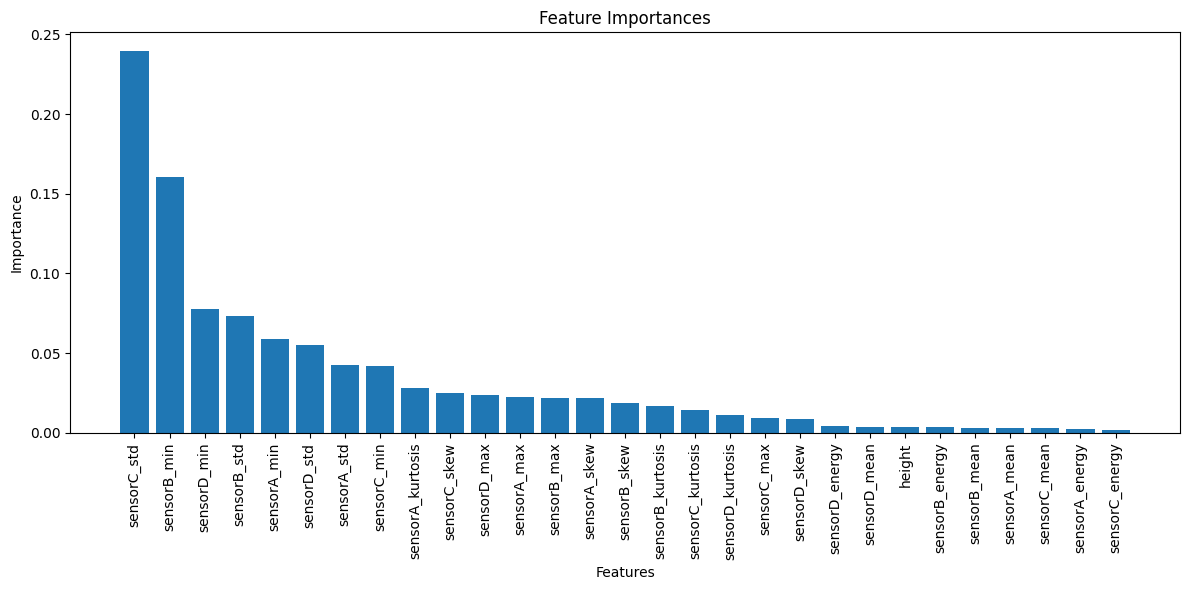

Top Features Selected: Index(['sensorC_std', 'sensorB_min', 'sensorD_min', 'sensorB_std',
       'sensorA_min', 'sensorD_std', 'sensorA_std', 'sensorC_min',
       'sensorA_kurtosis', 'sensorC_skew'],
      dtype='object')


In [16]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
features = X.columns

sorted_indices = np.argsort(importances)[::-1]
sorted_features = features[sorted_indices]
sorted_importances = importances[sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_features)), sorted_importances, align='center')
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

k = 10  
top_features = sorted_features[:k]
X_top = X[top_features]

X_top_scaled = scaler.fit_transform(X_top)
X_train_top, X_test_top, y_train, y_test = train_test_split(X_top_scaled, y, test_size=0.3, random_state=42)

print("Top Features Selected:", top_features)


In [3]:
def compute_dtoa(group):
    sensors = ['sensorA', 'sensorB', 'sensorC', 'sensorD']
    dtoa_features = {}
    
    for i in range(len(sensors)):
        for j in range(i + 1, len(sensors)):
            sensor_i = group[sensors[i]]
            sensor_j = group[sensors[j]]
            dtoa = sensor_i - sensor_j
            key = f"DToA_{sensors[i]}_{sensors[j]}"
            dtoa_features[key] = dtoa.mean()  

    dtoa_features['height'] = group['height'].iloc[0]  
    dtoa_features['x'] = group['x'].iloc[0]  
    dtoa_features['y'] = group['y'].iloc[0] 

    return pd.Series(dtoa_features)

In [4]:
import numpy as np

def compute_distances_and_filter(df):
    sensor_coordinates = {
        'sensorA': (33,30),
        'sensorB': (33, 287),
        'sensorC': (287,287),
        'sensorD': (287, 30),
    }
    
    valid_rows = []
    
    for index, row in df.iterrows():
        x_impact, y_impact = row['x'], row['y']
        
        distances = {}
        for sensor, (x_sensor, y_sensor) in sensor_coordinates.items():
            distances[sensor] = np.sqrt((x_sensor - x_impact)**2 + (y_sensor - y_impact)**2)
        
        times = {sensor: row[sensor] for sensor in sensor_coordinates.keys()}
        valid = True
        sensors = list(sensor_coordinates.keys())
        
        for i in range(len(sensors)):
            for j in range(i + 1, len(sensors)):
                sensor_i, sensor_j = sensors[i], sensors[j]
                if (times[sensor_i] <= times[sensor_j]) and (distances[sensor_i] > distances[sensor_j]):
                    valid = False
                    break
            if not valid:
                break
        
        if valid:
            valid_rows.append(row)
    
    return pd.DataFrame(valid_rows)

filtered_df = compute_distances_and_filter(df)

features_df = filtered_df.groupby('experimentNo').apply(compute_dtoa).reset_index(drop=True)

X = features_df.drop(columns=['x', 'y'])  
y = features_df[['x', 'y']]  

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)


Training Features Shape: (539, 7)
Testing Features Shape: (232, 7)
Training Target Shape: (539, 2)
Testing Target Shape: (232, 2)


C:\Users\kunal\AppData\Local\Temp\ipykernel_20400\1436262063.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_df = filtered_df.groupby('experimentNo').apply(compute_dtoa).reset_index(drop=True)


In [57]:
n_estimators = 30
max_depth = 8
max_samples = 280  
n_iterations = 10


model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_samples=max_samples
    )
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_test_x = y_test['x']
y_test_y = y_test['y']
y_pred_x = y_pred[:, 0]
y_pred_y = y_pred[:, 1]

r2_x = r2_score(y_test_x, y_pred_x)
rmse_x = np.sqrt(mean_squared_error(y_test_x, y_pred_x))
mae_x = mean_absolute_error(y_test_x, y_pred_x)

r2_y = r2_score(y_test_y, y_pred_y)
rmse_y = np.sqrt(mean_squared_error(y_test_y, y_pred_y))
mae_y = mean_absolute_error(y_test_y, y_pred_y)

print("Metrics for x-coordinate:")
print(f"R^2: {r2_x:.4f}, RMSE: {rmse_x:.4f}, MAE: {mae_x:.4f}")
print("Metrics for y-coordinate:")
print(f"R^2: {r2_y:.4f}, RMSE: {rmse_y:.4f}, MAE: {mae_y:.4f}")

r2_avg = (r2_x + r2_y) / 2
rmse_avg = (rmse_x + rmse_y) / 2
mae_avg = (mae_x + mae_y) / 2

print("Average Metrics:")
print(f"R^2: {r2_avg:.4f}, RMSE: {rmse_avg:.4f}, MAE: {mae_avg:.4f}")


Metrics for x-coordinate:
R^2: 0.6429, RMSE: 4.6177, MAE: 3.5989
Metrics for y-coordinate:
R^2: 0.6390, RMSE: 4.5774, MAE: 3.3539
Average Metrics:
R^2: 0.6410, RMSE: 4.5976, MAE: 3.4764


In [28]:
def evaluate_model(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"{dataset_name} Metrics:")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print("-" * 30)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

evaluate_model(y_train, y_train_pred, "Train")
evaluate_model(y_test, y_test_pred, "Test")

Train Metrics:
R²: 0.8443
RMSE: 3.0684
MAE: 2.3580
------------------------------
Test Metrics:
R²: 0.6542
RMSE: 4.5126
MAE: 3.4203
------------------------------


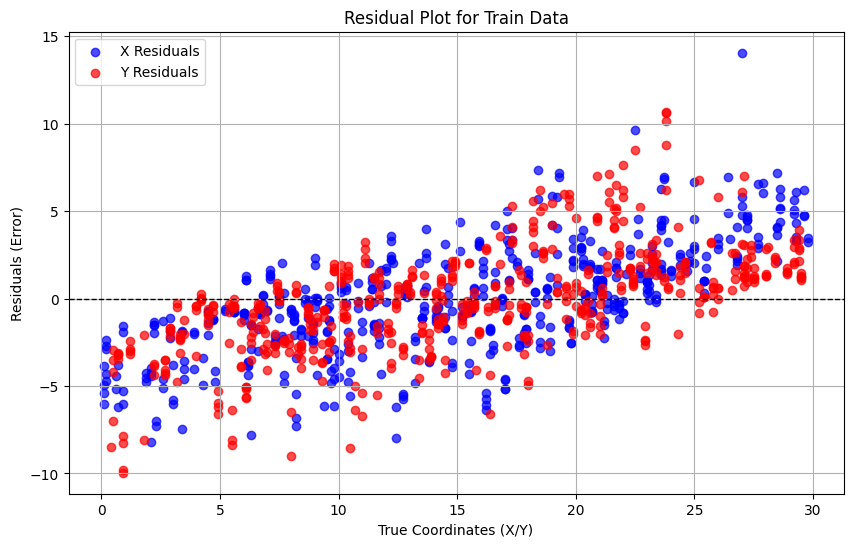

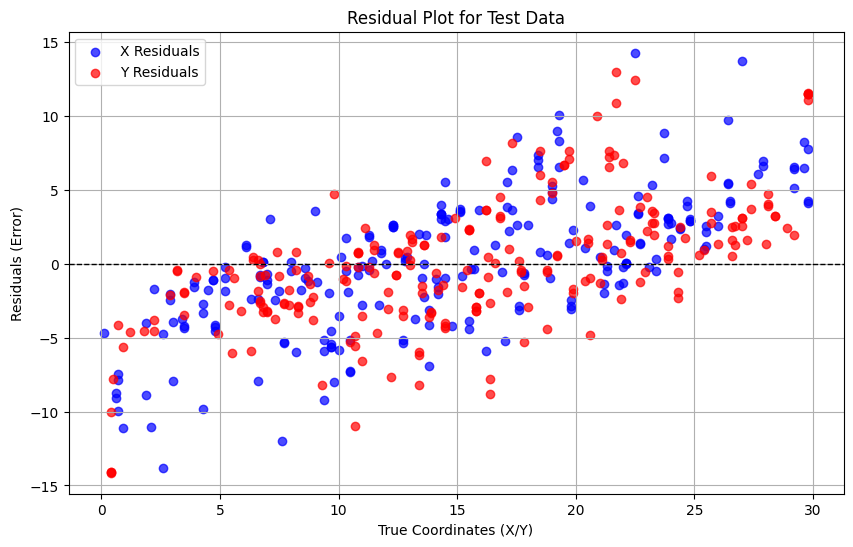

In [29]:
def plot_residuals(y_true, y_pred, dataset_name):
    residuals = y_true.values - y_pred
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true.values[:, 0], residuals[:, 0], color='blue', label='X Residuals', alpha=0.7)
    plt.scatter(y_true.values[:, 1], residuals[:, 1], color='red', label='Y Residuals', alpha=0.7)
    
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f'Residual Plot for {dataset_name}')
    plt.xlabel('True Coordinates (X/Y)')
    plt.ylabel('Residuals (Error)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_residuals(y_train, y_train_pred, "Train Data")
plot_residuals(y_test, y_test_pred, "Test Data")


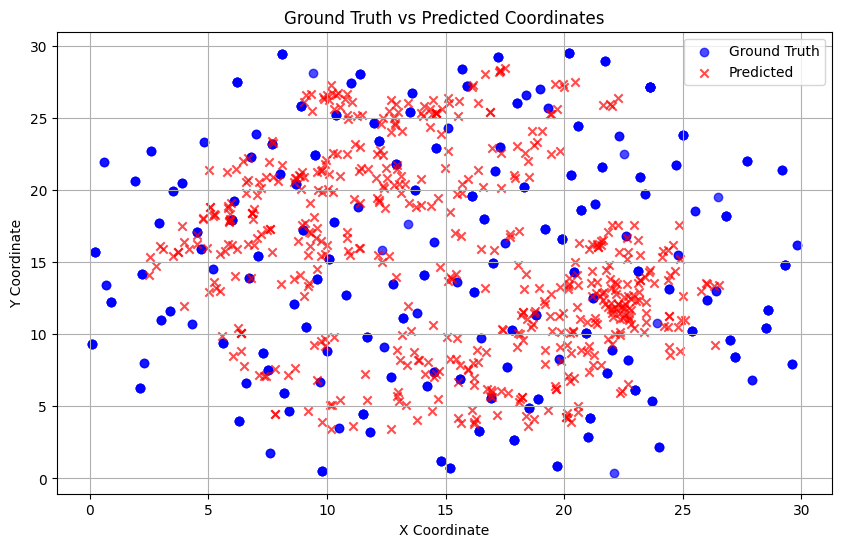

In [22]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    
    plt.scatter(y_true['x'], y_true['y'], color='blue', label='Ground Truth', alpha=0.7)
    
    plt.scatter(y_pred[:, 0], y_pred[:, 1], color='red', label='Predicted', alpha=0.7, marker='x')
    
    plt.title('Ground Truth vs Predicted Coordinates')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

y_train_pred = model.predict(X_train)
plot_predictions(y_train, y_train_pred)


In [50]:
param_grid = {
    'n_estimators': [50, 100, 150],  
    'max_depth': [5, 10, 15,30], 
    'max_samples': [0.7, 0.8, 0.9,280],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4], 
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5, 
    scoring='r2', 
    verbose=2, 
    n_jobs=-1  
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'max_depth': 15, 'max_samples': 0.9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best R² Score: 0.7495087526240797


In [32]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

evaluate_model(y_train, y_train_pred, "Train")
evaluate_model(y_test, y_test_pred, "Test")

Train Metrics:
R²: 0.9711
RMSE: 1.3206
MAE: 0.8996
------------------------------
Test Metrics:
R²: 0.7306
RMSE: 3.9812
MAE: 2.6865
------------------------------
